In [1]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score

c:\Users\Alessandro\anaconda3\envs\tfgpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train=pd.read_csv('train.csv')

# House price regression using TensorFlow

I have to: 

1) load the data

2) apply some basic feature engineering and cleaning

3) encode and normalize the data into something that can be efficiently computed by tensorflow

4) train the model, score it and compute metrics

5) check the model predictions visually

6) predict the house prices in the test set

Fore more info:

https://www.tensorflow.org/tutorials/load_data/pandas_dataframe

https://www.tensorflow.org/tutorials/load_data/csv

https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers?authuser=2

https://www.tensorflow.org/guide/keras/preprocessing_layers

In [3]:
from house_prices import feat_eng

In [84]:
int_cat_f=['SaleCondition','ExterQual','Neighborhood','KitchenQual','SaleType','PoolQC']
int_num_f=['OverallQual','LotArea','BsmtFinSF1','TotalBsmtSF','GrLivArea','GarageArea','YearBuilt','GarageCars','TotRmsAbvGrd']
#int_ord_f=['GarageCars','TotRmsAbvGrd']#int64

In [5]:
label='SalePrice'


### First implementation: only using numeric features and model.fit() method

In [6]:
feat_eng(train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs,AvgSF
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,2,2008,WD,Normal,208500,1710,2.0,855.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,5,2007,WD,Normal,181500,1262,1.0,1262.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,9,2008,WD,Normal,223500,1786,2.0,893.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,2,2006,WD,Abnorml,140000,1717,2.0,858.5
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,12,2008,WD,Normal,250000,2198,2.0,1099.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,8,2007,WD,Normal,175000,1647,2.0,823.5
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,2,2010,WD,Normal,210000,2073,1.0,2073.0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,Shed,2500,5,2010,WD,Normal,266500,2340,2.0,1170.0
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,4,2010,WD,Normal,142125,1078,1.0,1078.0


In [7]:
#
x,y=train.drop(label,axis=1),train[label]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [8]:
train_num_feat,test_num_feat=x_train[int_num_f],x_test[int_num_f]
tf.convert_to_tensor(train_num_feat)
tf.convert_to_tensor(test_num_feat)
tf.convert_to_tensor(y_test)
tf.convert_to_tensor(y_train)


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(train_num_feat)


In [9]:
train_num_feat

,OverallQual,LotArea,BsmtFinSF1,TotalBsmtSF,GrLivArea,GarageArea,YearBuilt
64,7,9375,739,1057,2034,645,1997
682,6,2887,1003,1291,1291,431,1996
960,5,7207,696,858,858,0,1958
1384,6,9060,204,560,1258,280,1939
1100,2,8400,290,290,438,246,1920
...,...,...,...,...,...,...,...
763,8,9430,1163,1252,2365,856,1999
835,4,9600,442,1067,1067,436,1950
1216,6,8930,0,0,1902,539,1978
559,7,3196,0,1374,1557,420,2003


In [41]:
def get_basic_model():
  model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredLogarithmicError()])
  return model

In [ ]:
model= get_basic_model()
history=model.fit(train_num_feat, y_train, epochs=20, batch_size=15,validation_data=(test_num_feat,y_test))


### Excercise 2: preprocess by using keras functional API

1) Build the preprocessing model, passing data as dict

2) numerical features should be normalized

3) categorical features should be one hot encoded

In [84]:
train[:5]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotFlrSF,nFlrs,AvgSF
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,2,2008,WD,Normal,208500,1710,2.0,855.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,5,2007,WD,Normal,181500,1262,1.0,1262.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,9,2008,WD,Normal,223500,1786,2.0,893.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,2,2006,WD,Abnorml,140000,1717,2.0,858.5
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,12,2008,WD,Normal,250000,2198,2.0,1099.0


In [85]:
print(int_cat_f,int_num_f)

['SaleCondition', 'ExterQual', 'Neighborhood', 'KitchenQual', 'SaleType', 'PoolQC'] ['OverallQual', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'YearBuilt', 'GarageCars', 'TotRmsAbvGrd']


In [89]:
inputs = {}
for name in int_num_f+int_cat_f:
    if name in int_num_f:
        dtype = tf.float32
    if (name in int_cat_f):
        dtype = tf.string
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
inputs

{'OverallQual': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'OverallQual')>,
 'LotArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'LotArea')>,
 'BsmtFinSF1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BsmtFinSF1')>,
 'TotalBsmtSF': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'TotalBsmtSF')>,
 'GrLivArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GrLivArea')>,
 'GarageArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageArea')>,
 'YearBuilt': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'YearBuilt')>,
 'GarageCars': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageCars')>,
 'TotRmsAbvGrd': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'TotRmsAbvGrd')>,
 'SaleCondition': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'SaleCondition')>,
 'ExterQual': <KerasTensor: shape=(None, 1) dtype=string (created b

#### Numeric inputs:

Concatenate the numeric input layers:

In [90]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(train[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'normalization_5')>

In [91]:
preprocessed_inputs = [all_numeric_inputs]

#### Categorical inputs

#### Create the preprocessing layer

#### Create the model

In [ ]:
def create_model(preprocessing_head, inputs:dict):

  preprocessed_inputs = preprocessing_head(inputs)
  x=tf.keras.layers.Dense(100)(preprocessed_inputs)
  x=tf.keras.layers.Dropout(0.25)(x)
  x=tf.keras.layers.Dense(100)(x)
  result = tf.keras.layers.Dense(1)
  
  model = tf.keras.Model(inputs, result)

  model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanSquaredLogarithmicError()])
  return model

titanic_model = create_model(preprocessing, inputs_dict)

### Make predictions and score

In [32]:
predictions=model.predict(test_num_feat)

14/14 [==============================] - 0s 3ms/step


In [34]:
def score_and_visualize(model,x_test,y_test):
    predictions=model.predict(x_test).flatten()
    print(predictions.shape)
    plt.figure(figsize=(10,10))
    plt.scatter(y_test,predictions)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    msle=mean_squared_log_error(y_true=y_test, y_pred=predictions)#msle is the metric evaluated in the kaggle challange
    r2=r2_score(y_true=y_test, y_pred=predictions)
    print('r2 coefficient: ',r2,'\nmsle = ', msle)
    z = np.polyfit(y_test, predictions, 1)
    print(z)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')
    plt.axline((0,0),slope=1,ls='--')
    plt.show()

14/14 [==============================] - 0s 3ms/step
(438,)
r2 coefficient:  0.6903404983495648 
msle =  0.026972728602518217
[8.50754444e-01 2.84780810e+04]


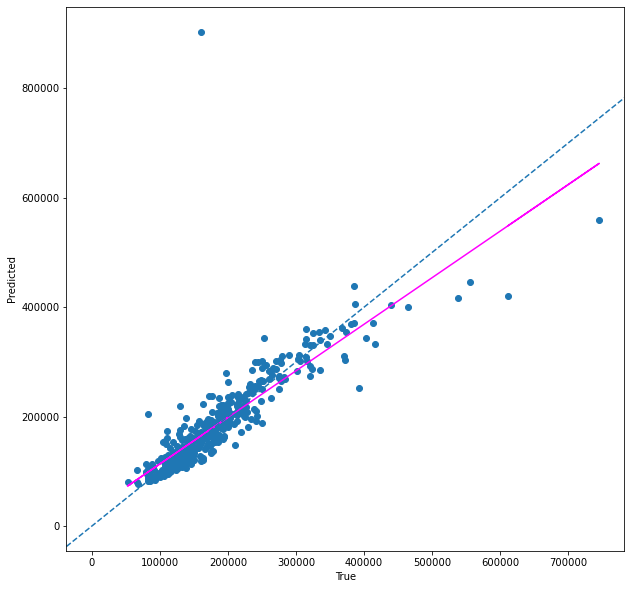

In [35]:
score_and_visualize(model=model,x_test=test_num_feat,y_test=y_test)


Save predictions

In [36]:
import datetime

In [37]:
write=False

test=pd.read_csv('test.csv')
test=test[int_num_f]
tf.convert_to_tensor(test)
pred=model.predict(test)
out_df=pd.read_csv('sample_submission.csv')
out_df['SalePrice']=pred
if write:
    out_df.to_csv('prediction_tf.csv',index=False)

46/46 [==============================] - 0s 3ms/step


Save model

In [38]:
savemodel=False
if savemodel:
    timestamp=datetime.datetime.now().strftime("%d%m%Y%H%M%S")
    models_folder= 'models'
    os.makedirs(models_folder,exist_ok=True)
    model_name= 'model_'+ timestamp +'_tf.h5'
    modelpath= os.path.join(models_folder,model_name)
    model.save(modelpath)
    print('Saved ' , modelpath)

Saved  models\model_09112022114201_tf.h5
